In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from classes import Bandpasses, LightCurve

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

In [51]:
# load the LSST bandpasses
bandpasses = Bandpasses()

### Dictionaries to hold everything to come

In [23]:
data_loc = 'plasticc_data/'
file_dict = {'SNIa':'SNIa_SkyObjects.pkl', 'SNII-1':'SNII_SkyObjects.pkl', 'SNII-2':'SNII_SkyObjects.pkl', 'SNII-3':'SNII_SkyObjects.pkl'}

sne_dict = dict()
lc_dict = dict()
tset_dict = dict()

tmin_dict = {'SNIa':-19, 'SNII-1':-25, 'SNII-2': -8, 'SNII-3':-19}
tmax_dict = {'SNIa': 90, 'SNII-1':100, 'SNII-2':155, 'SNII-3': 90}

color_dict = {'lsstu':'C4', 'lsstg':'C2', 'lsstr':'C3', 'lssti':'C1', 'lsstz':'k', 'lssty':'C5'}

### Load the data

In [24]:
for snType,file in file_dict.items():
    
    # keep only data point in the phase range (tmin,tmax)
    tmin = tmin_dict[snType]
    tmax = tmax_dict[snType]
    
    # keep only fluxes with ferr <= ferr_cut
    ferr_cut = 0.05
    
    with open(data_loc + file_dict[snType], 'rb') as input:
        
        sne = []
        for sn in pickle.load(input):
            time = sn.photometry['mjd'] - sn.t0
            sn.photometry = sn.photometry[(time >= tmin) & (time <= tmax)]
            sn.photometry = sn.photometry[np.abs(sn.photometry['flux_err']/sn.photometry['flux']) <= ferr_cut]    
            if len(sn.photometry) > 0 and sn.source == snType:
                sne.append(sn)
        print(f'{snType}: {len(sne)}')
        sne_dict[snType] = sne

SNIa: 1533
SNII-1: 414
SNII-2: 320
SNII-3: 74


### Functions

In [57]:
def plot_photometry(snType):
    
    fig,ax = plt.subplots()
    
    sne = sne_dict[snType]
    tmin = tmin_dict[snType]
    tmax = tmax_dict[snType]
    
    for sn in sne:
        time = sn.photometry['mjd'] - sn.t0
        fluxes = sn.photometry['flux']
        colors = [color_dict[band] for band in sn.photometry['filter']]
        plt.scatter(time, fluxes, c=colors, marker='.', s=0.5)
        
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Flux Density')
    ax.set_xlim(tmin - 5, tmax + 5)
    
    for name,c in color_dict.items():
        ax.scatter([tmin - 10], [1], c=c, label=name, marker='o')
    ax.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)
    
    ax.text(0.9, 0.8, snType, transform=ax.transAxes, ha='right', va='top')
    
    
def learn_lc(snType, tstep=1, w=1, dmse_stop=0.05, Ncpus=8):
    
    print(snType)

    # create the initial null lightcurve
    tmin = tmin_dict[snType]
    tmax = tmax_dict[snType]
    time = np.arange(tmin, tmax + tstep, tstep)
    wavelen = np.arange(1700, 12100, 100)
    lc = LightCurve(time, wavelen)
    lc.null()
    
    # get the supernovae
    sne = sne_dict[snType]

    # create the training sets
    training_sets = lc.training_sets(sne)

    # list empty training sets
    empty_sets = [t for t,val in training_sets.items() if len(val) == 0]
    if len(empty_sets) > 0:
        print(f'The following training sets are empty:{empty_sets}')
        print('Removing those time slices')
    
        # remove all the empty time slices
        for t in empty_sets:
            time = np.delete(time, np.where(time == t))
            del training_sets[t]
        lc = LightCurve(time, wavelen)
        lc.null()

    # calculate the initial wMSE
    mse0 = lc.mse(training_sets, bandpasses, Ncpus=Ncpus)
    print(f'mse0: {mse0:.2f}')

    # train the lightcurve
    lc.train(training_sets, bandpasses, w=w, dmse_stop=dmse_stop, Ncpus=Ncpus)  

    # calculate final wMSE
    msef = lc.mse(training_sets, bandpasses, Ncpus=Ncpus)
    print(f'msef: {msef:.2f}')
    
    # calculate fractional change in wMSE
    print(f'dmse: {(msef-mse0)/mse0:.2f}')
    
    tset_dict[snType] = training_sets
    lc_dict[snType] = lc

def plot_trained_tslice(snType,time):
    
    lc = lc_dict[snType]
    tset = tset_dict[snType][time]
    
    fig,ax = plt.subplots()
    
    sed = lc.sed_slice(time)
    ax.plot(sed.wavelen, sed.flambda, lw=2, alpha=0.4)
    
    for sn in tset:
        filters = sn.photometry['filter']
        wavelen = bandpasses.mean_wavelens(filters)/(1 + sn.specz)
        fluxes = sn.photometry['flux']
        fluxerrs = sn.photometry['flux_err']
        colors = [color_dict[band] for band in sn.photometry['filter']]
        plt.errorbar(wavelen, fluxes, fluxerrs, c=colors, linestyle='None')
        
    for name,c in color_dict.items():
        ax.scatter([-10], [1], c=c, label=name, marker='o')
    ax.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)

    ax.text(0.9, 0.8, f't = {time}', transform=ax.transAxes, ha='right', va='top')

    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Flux Density')
    ax.set_xlim(1700, 12000)
    ax.set_ylim(0,None)

### SNIa

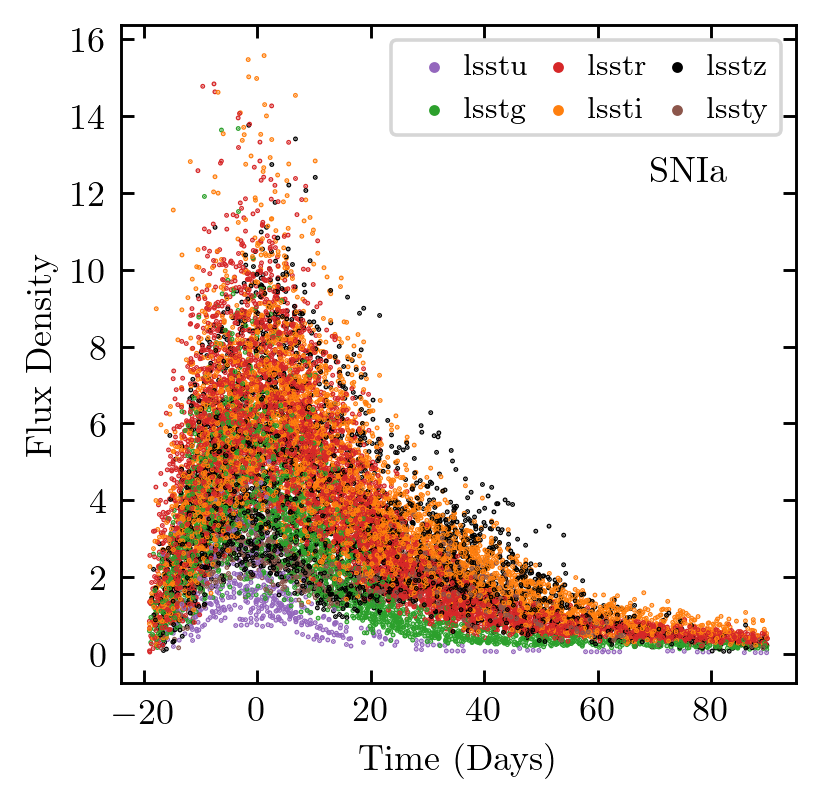

In [49]:
plot_photometry('SNIa')

In [54]:
learn_lc('SNIa')

SNIa
mse0: 118446.96
msef: 9027.84
dmse: -0.92


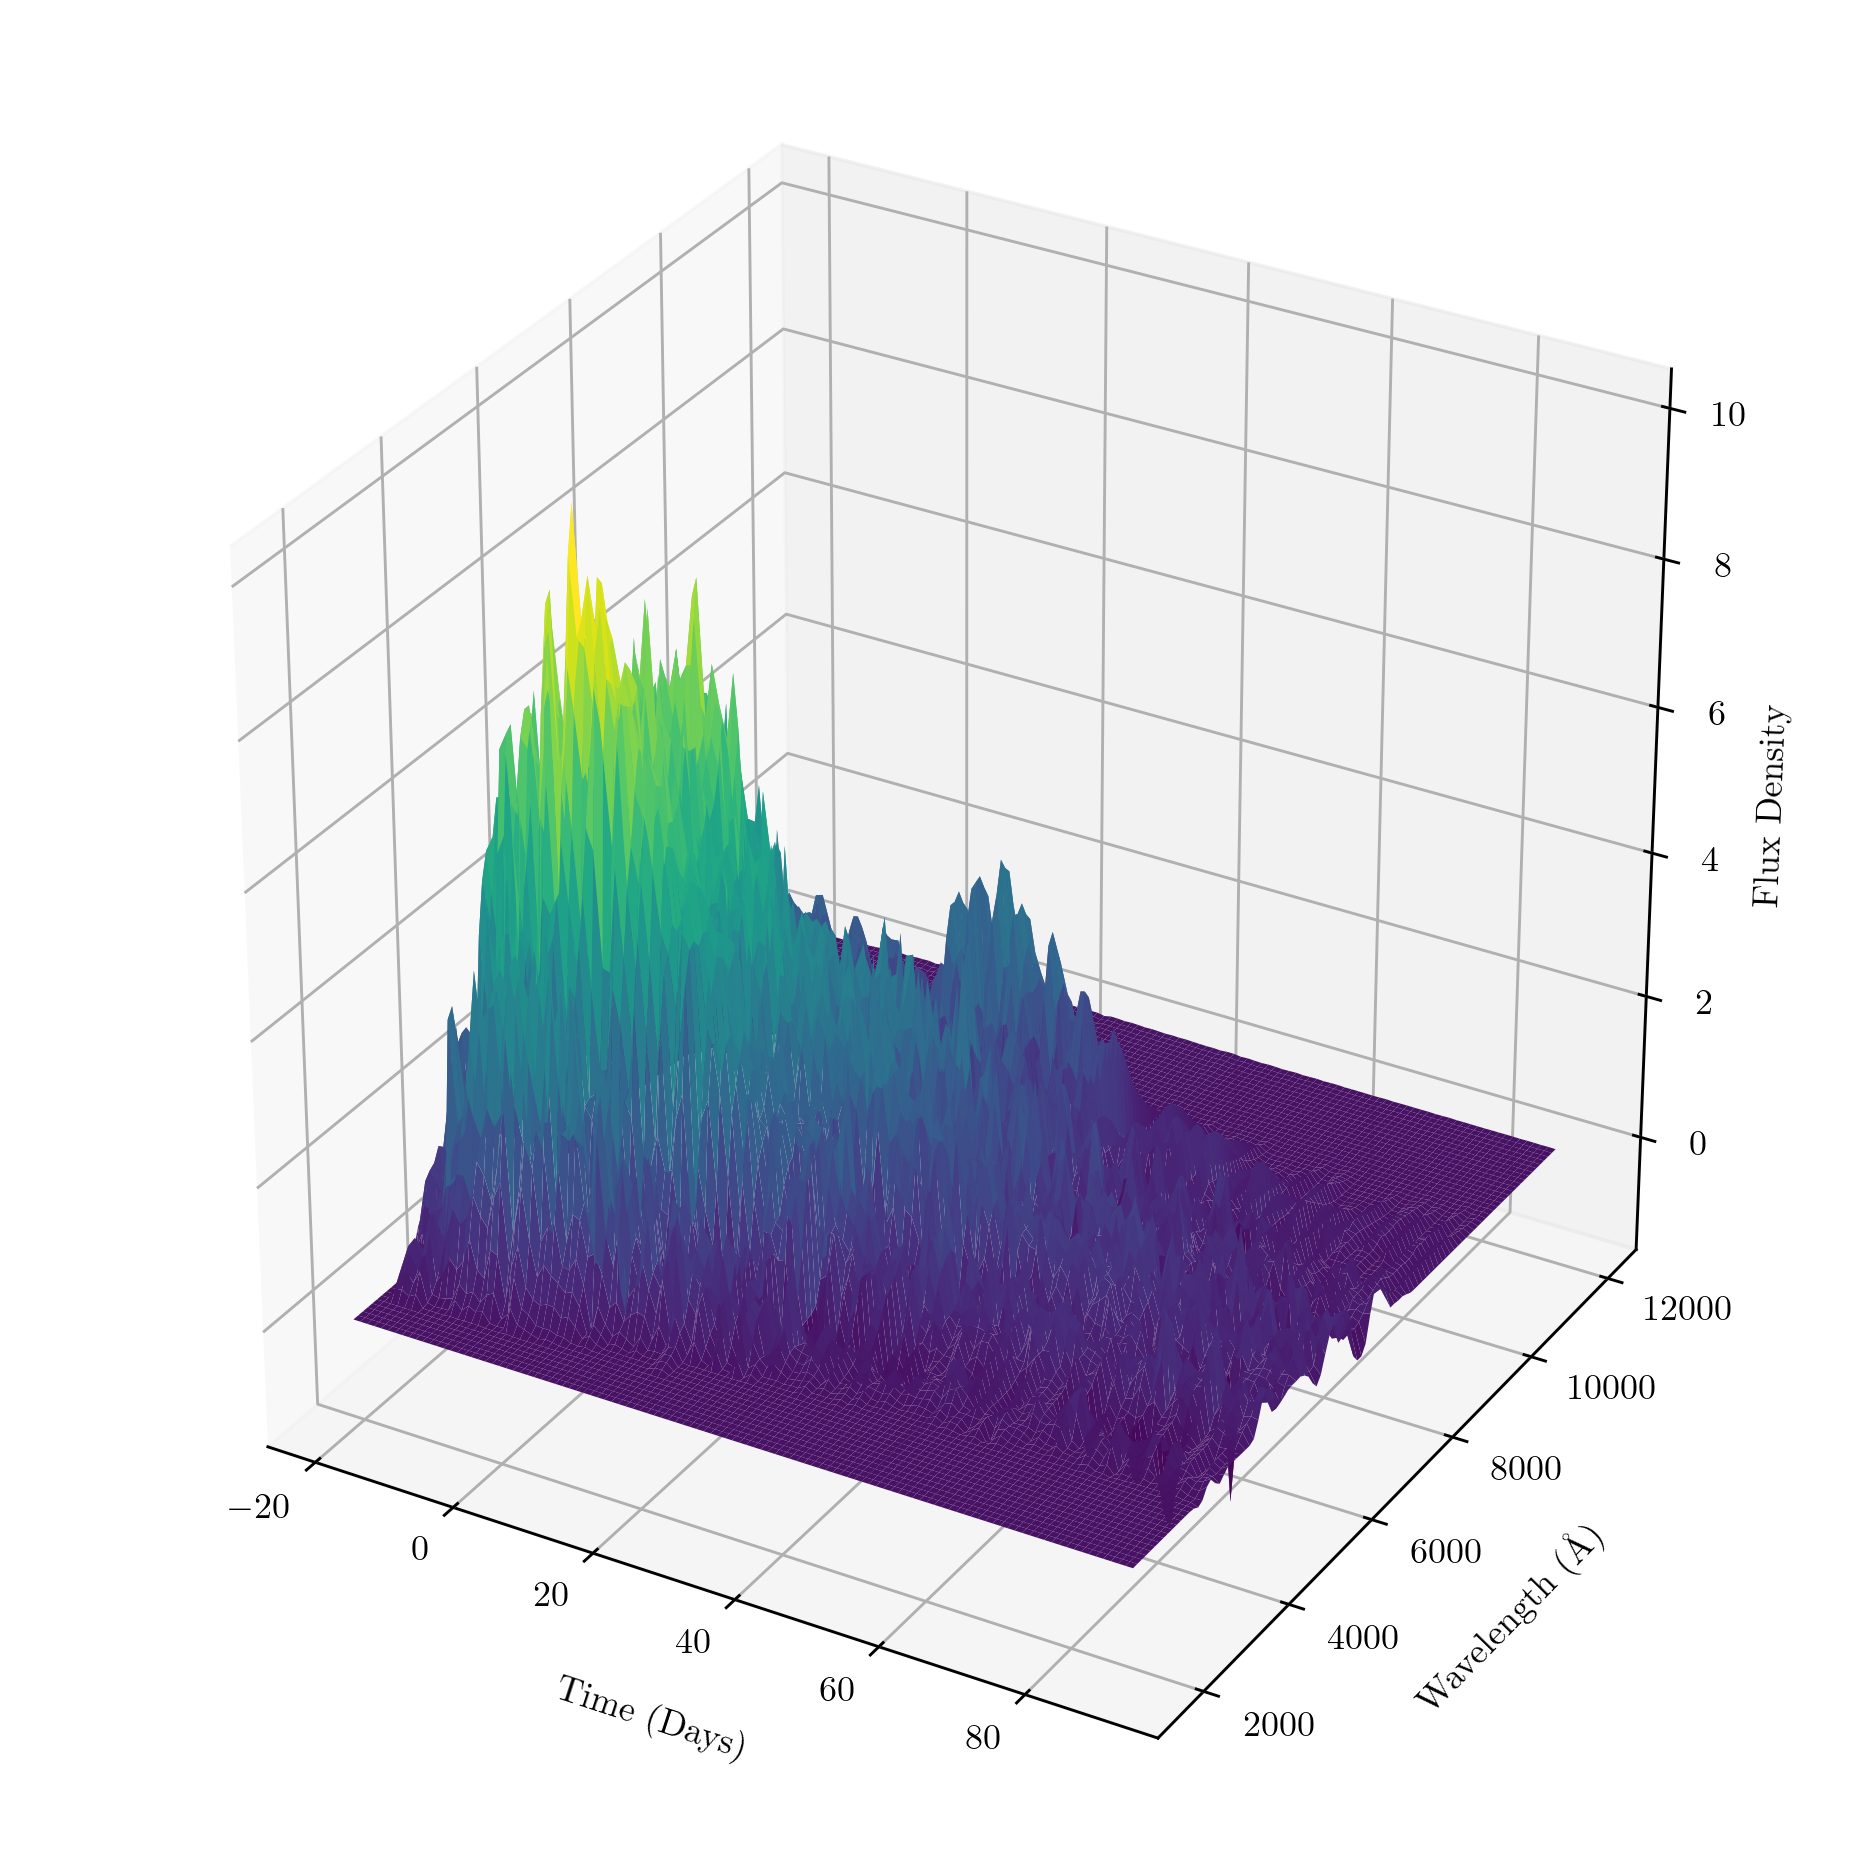

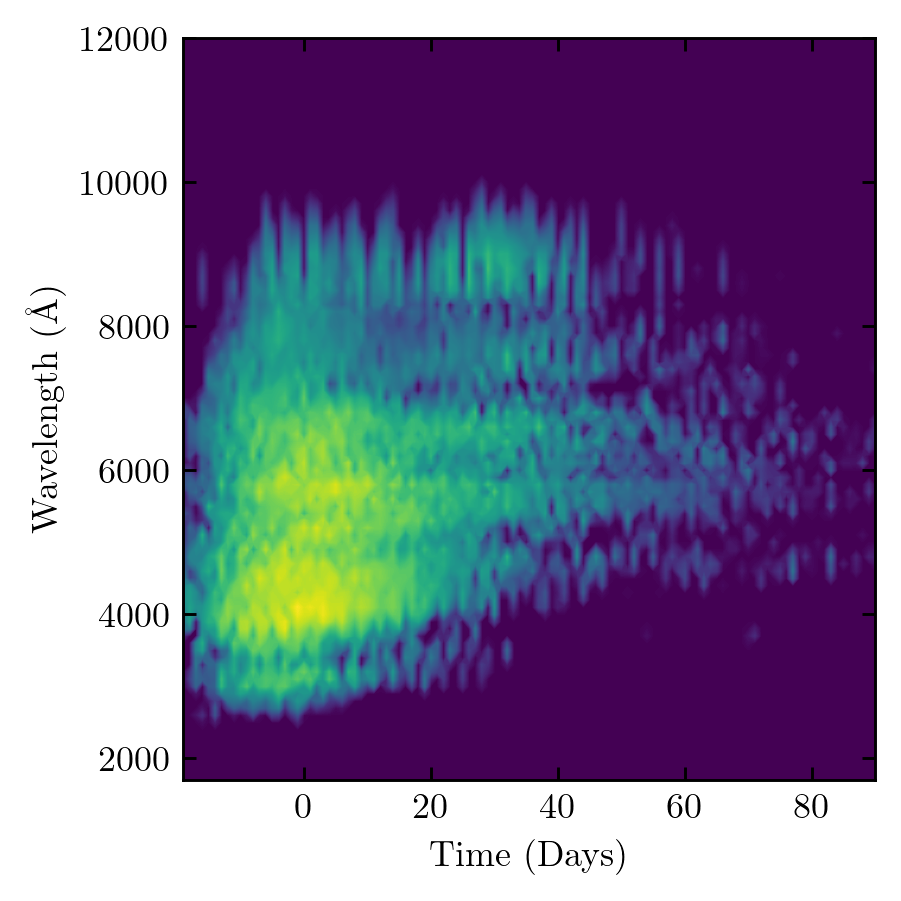

In [55]:
lc = lc_dict['SNIa']
lc.surface_plot()
lc.contour_plot()
plt.show()

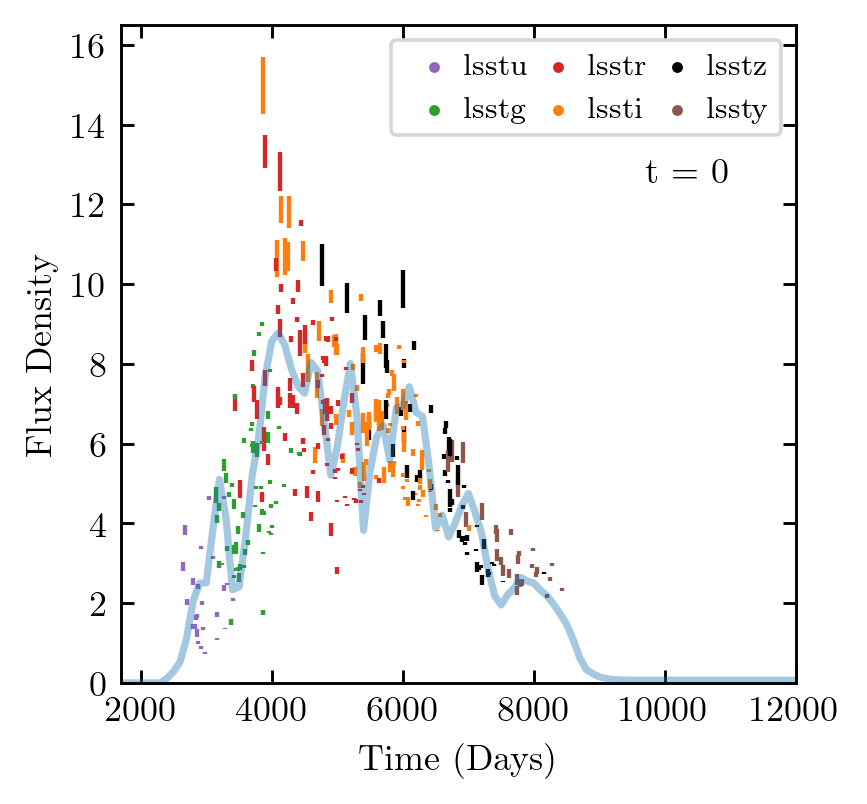

In [58]:
plot_trained_tslice('SNIa', 0)

### SNII-2 (SNII-NMF)

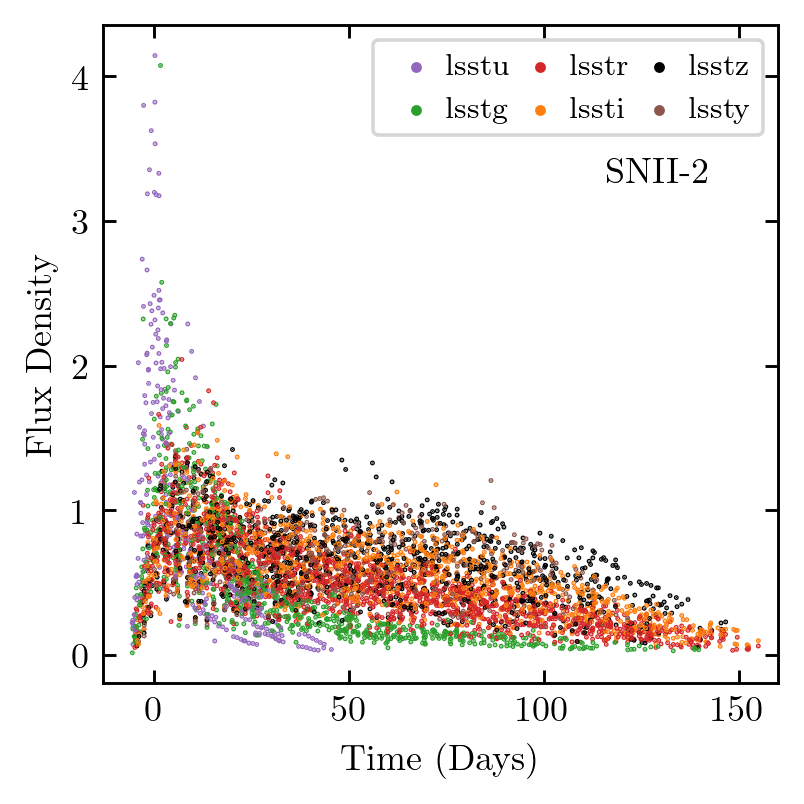

In [50]:
plot_photometry('SNII-2')

In [41]:
learn_lc('SNII-2', tstep=4, w=2)

SNII-2
The following training sets are empty:[-8]
Removing those time slices
mse0: 4317.00
msef: 381.52
dmse: -0.91


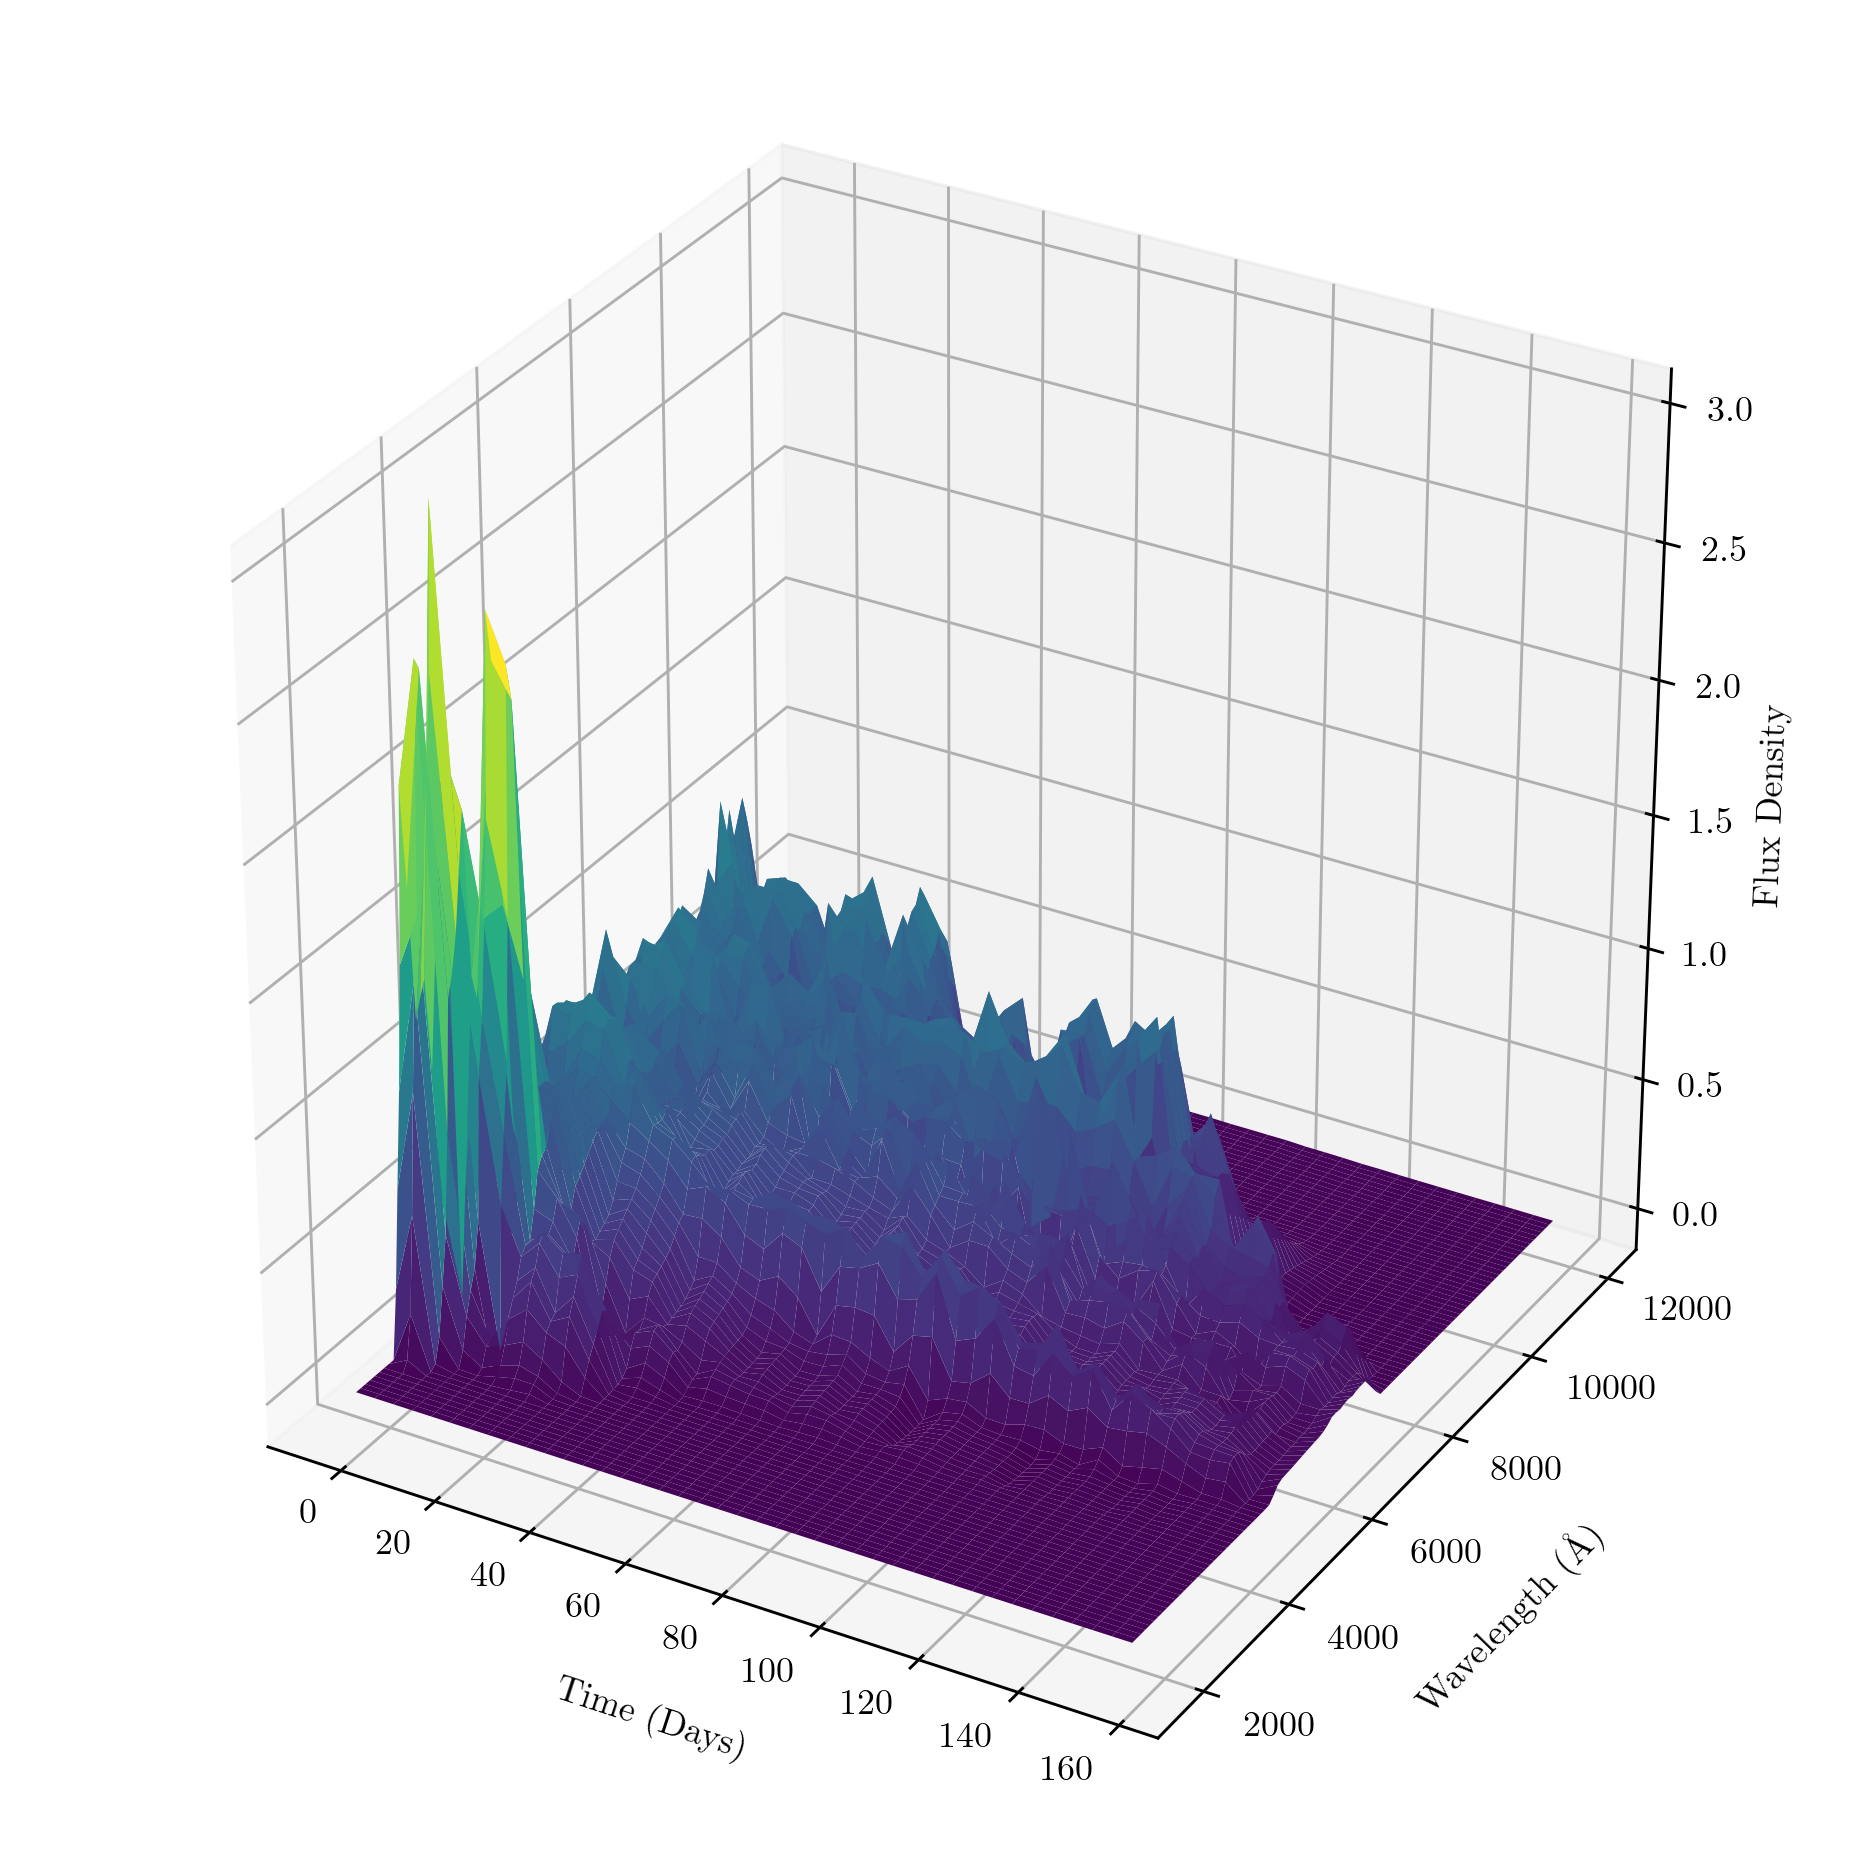

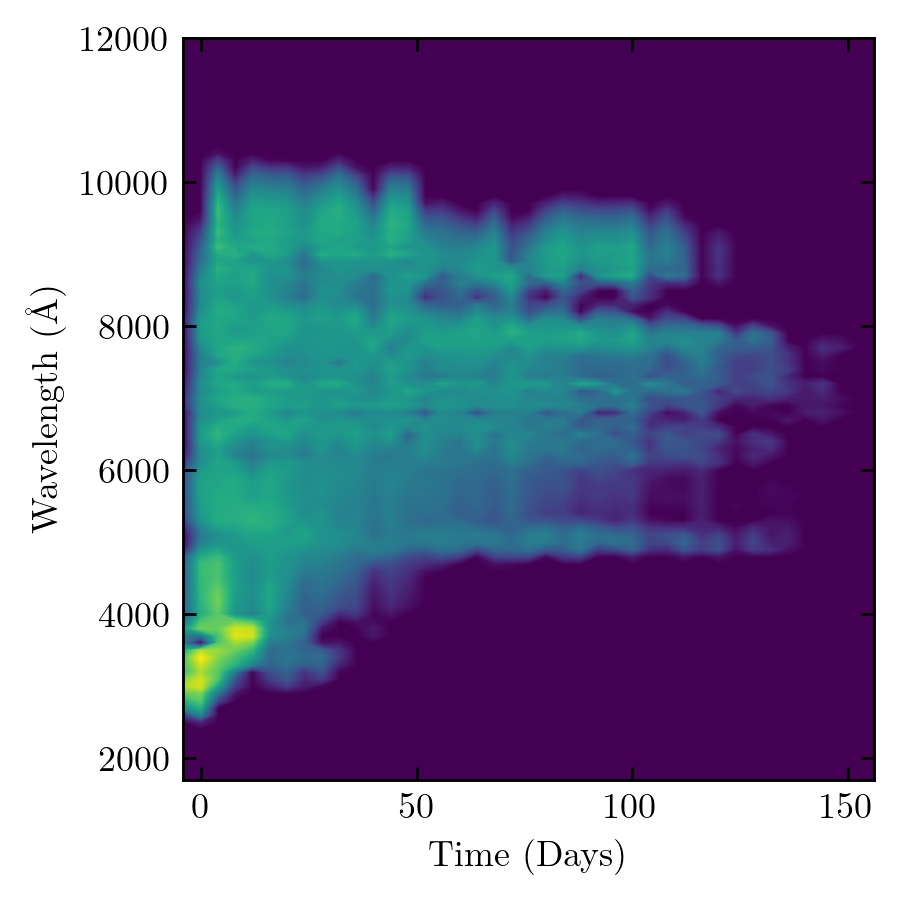

In [42]:
lc = lc_dict['SNII-2']
lc.surface_plot()
lc.contour_plot()
plt.show()

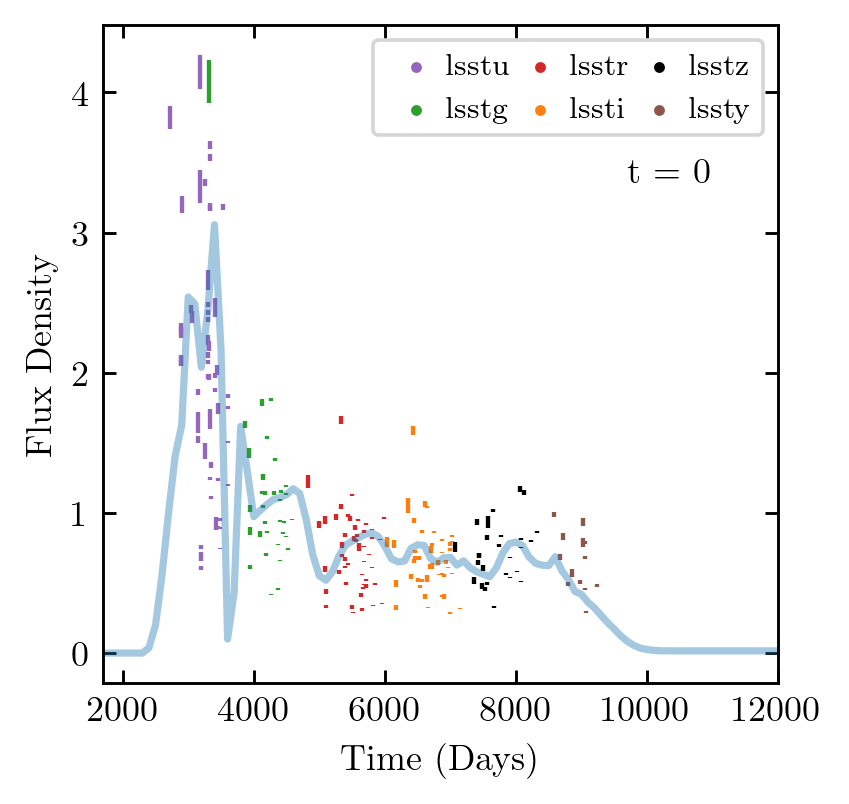

In [52]:
plot_trained_tslice('SNII-2', 0)

### SNII-1 (SNII-Templates)

### SNII-3 (SNII-MOSFIT)